In [ ]:
pip install colorama

In [ ]:
pip install -U ipywidgets

In [5]:
# Standard imports
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from skimage import io

import seaborn as sns
from tqdm import trange, tqdm
from colorama import Fore
from glob import glob
import json
from pprint import pprint
import time
import cv2
from enum import Enum
from IPython.display import display, HTML, Image, Video

import random
import inspect
from uuid import uuid4

# For Data preparation
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *

In [6]:
%pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/14/db/f1ec308131cf4bf2f5f3a43a679dbef06e67e45525492be551b21e9e19d7/ultralytics-8.1.6-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 14.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (AMD EPYC 7B12)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5359.4/8062.4 GB disk)


In [8]:
class Config:
    IMG_SIZE = 512
    DATA_PATH = "/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data"
    COLS = [
        "image_id",
        "path",
        "bbox",
        "label",
        "width",
        "height"
    ]
    ORIGINAL_IMG_SHAPE = (512, 512)
    CONFIG_FILENAME = "weed_data"
    OUTPUT_PATH = "./output"
    EPOCHS = 20
    BATCH_SIZE = 32

In [9]:
def process_data(data_df: "pandas dataFrame", image_id_col: str, bbox_col: str, label_col: str, path_col: str, config_filename="data", test_size=0.1):
    """
    Helper function to build dataset for yolo training
        > Yolo expects the data in the form: (label, x_center, y_center, Width,  Height)
        > return df_train, df_val
    """
    os.system("git clone https://github.com/ultralytics/ultralytics")
    OUTPUT_FOLDER_NAME = Config.OUTPUT_PATH.split("/")[-1]
    if not os.path.exists(Config.OUTPUT_PATH):
        os.system(
            f'''
                cd ./yolov8
                mkdir {OUTPUT_FOLDER_NAME}
                cd {OUTPUT_FOLDER_NAME}
                mkdir images
                mkdir labels
                cd images
                mkdir train
                mkdir validation
                cd ..
                cd labels
                mkdir train
                mkdir validation
                cd ../../
                tree {OUTPUT_FOLDER_NAME}
                cd ../
            ''')

    # For converting string form of list to original form
    if isinstance(data_df.bbox.values[0], str):
        data_df.bbox = data_df.bbox.apply(ast.literal_eval)

    # Encoding all labels
    mapper = {k: d for d, k in enumerate(sorted(data_df[label_col].unique()))}
    data_df[label_col] = data_df[label_col].apply(lambda x: int(mapper[x]))

    # Grouping the bounding boxes and paths wrt label_col
    grpBy_obj = data_df.groupby(by=[image_id_col, path_col])
    bbox_df = grpBy_obj[bbox_col].apply(list).reset_index(name=bbox_col)
    label_df = grpBy_obj[label_col].apply(list).reset_index(name=label_col)

    label_df[label_col] = label_df[label_col].apply(lambda x: x  if len(set(x)) > 1 else x[0])

    data_df = bbox_df.merge(label_df, on = [image_id_col, path_col], how = "inner")

    # Dividing the data into train and val set
    df_train, df_val = train_test_split(data_df, test_size = test_size, shuffle = 1, random_state = 42)
    df_train = df_train.reset_index(drop = 1)
    df_val = df_val.reset_index(drop = 1)

    print(f"[INFO] Train_SHAPE : {df_train.shape}, VAL_SHAPE: {df_val.shape}")

    data_dict = {"train": df_train, "validation": df_val}
    for data_type, data in data_dict.items():
        for idx in trange(len(data), desc=f"Processing {data_type}...", bar_format="{l_bar}%s{bar:50}%s{r_bar}" % (Fore.CYAN, Fore.RESET), position=0, leave=True):
            row = data.loc[idx]
            image_name = row[image_id_col]
            bounding_boxes = row[bbox_col]
            labels = row[label_col]
            path = row[path_col]
            yolo_data = []
            for bbox in bounding_boxes:
                x = bbox[0]
                y = bbox[1]
                w = bbox[2]
                h = bbox[3]

                x_center = x + w/2
                y_center = y + h/2

                # Normalizing the center co-ordiantes, w and h
                W, H = Config.ORIGINAL_IMG_SHAPE
                x_center /= W; w /= W
                y_center /= H; h /= H

                if isinstance(labels, list):
                    for label in labels:
                        yolo_data.append([label, x_center, y_center, w, h])
                else:
                    yolo_data.append([labels, x_center, y_center, w, h])

            yolo_data = np.array(yolo_data)
            np.savetxt(
                f"{Config.OUTPUT_PATH}/labels/{data_type}/{image_name}.txt",
                yolo_data,
                fmt=["%d", "%f", "%f", "%f", "%f"]
            )

            # Copying the image to the output folder
            os.system(
                f"""
                cp {path} {Config.OUTPUT_PATH}/images/{data_type}/{path.split("/")[-1]}
                """
            )

    # Creating the data yaml file
    with open(f"./{config_filename}.yaml", "w+") as file_:
        file_.write(
            f"""

            train: {OUTPUT_FOLDER_NAME}/images/train
            val: {OUTPUT_FOLDER_NAME}/images/validation
            nc: {len(mapper)}
            names: {list(mapper.keys())}

            """
        )
    file_.close()
    print("[INFO] Done with data processing")





def predict(images_path:"path to the test images", weights_path: "path to the weights folder"):
    """
    Helper function to make predictions over images using Yolo
    """
    os.system(f"python ultralytics/detect.py --source {images_path} --weights {weights_path}")

# Loading dataset

In [10]:
classes_mapper = {
    0: "crop",
    1: "weed"
}

images_list = list(filter(lambda x: x.split(".")[1] == "jpeg", os.listdir(Config.DATA_PATH)))
txts_list = list(filter(lambda x: x.split(".")[1] == "txt", os.listdir(Config.DATA_PATH)))

classes_mapper

{0: 'crop', 1: 'weed'}

In [11]:
counter = [0, 0, 0]
for txt_file in txts_list:
    coords = list(map(lambda x: x.replace("\n", ""), open(f"{Config.DATA_PATH}/{txt_file}", "r").readlines()))
    for coord in coords:
        label, _, _, _, _ = coord.split()
        counter[int(label)] += 1

for i in range(2):
    print(f"{classes_mapper[i]} : {counter[i]}")

crop : 1212
weed : 860


In [12]:
df = pd.DataFrame(columns = Config.COLS)

for txt_file in txts_list:
    img_file = f"{txt_file.split('.')[0]}.jpeg"
    bboxes = list(map(lambda x: x.replace("\n", ""), open(f"{Config.DATA_PATH}/{txt_file}").readlines()))
    for bbox in bboxes:
        label, x_center, y_center, W, H = bbox.split()
        label = int(label)
        x_center, y_center, W, H = list(map(lambda x: float(x), [x_center, y_center, W, H]))
        x1 = int(512*(x_center - W/2))
        x2 = int(512*(x_center + W/2))
        y1 = int(512*(y_center - H/2))
        y2 = int(512*(y_center + H/2))
        image_id = img_file.split(".")[0]
        path = f"{Config.DATA_PATH}/{img_file}"
        bbox = [x1, y1, x2, y2]
        label = classes_mapper[label]
        width = height = Config.IMG_SIZE

        # Appending row to the df
        row = [image_id, path, bbox, label, width, height]
        df.loc[len(df)] = row

df

,image_id,path,bbox,label,width,height
0,agri_0_9032,/kaggle/input/crop-and-weed-detection-data-wit...,"[16, 200, 497, 423]",crop,512,512
1,agri_0_8733,/kaggle/input/crop-and-weed-detection-data-wit...,"[157, 148, 464, 437]",weed,512,512
2,agri_0_6120,/kaggle/input/crop-and-weed-detection-data-wit...,"[48, 0, 512, 502]",crop,512,512
3,agri_0_4362,/kaggle/input/crop-and-weed-detection-data-wit...,"[88, 107, 444, 394]",weed,512,512
4,agri_0_9055,/kaggle/input/crop-and-weed-detection-data-wit...,"[108, 123, 392, 312]",weed,512,512
...,...,...,...,...,...,...
2067,agri_0_5641,/kaggle/input/crop-and-weed-detection-data-wit...,"[61, 23, 456, 458]",crop,512,512
2068,agri_0_7824,/kaggle/input/crop-and-weed-detection-data-wit...,"[98, 125, 452, 390]",weed,512,512
2069,agri_0_2854,/kaggle/input/crop-and-weed-detection-data-wit...,"[71, 2, 472, 452]",crop,512,512
2070,agri_0_8899,/kaggle/input/crop-and-weed-detection-data-wit...,"[253, 104, 411, 421]",weed,512,512


[237] x1, y1, x2, y2:  43 383 96 432
Label: crop


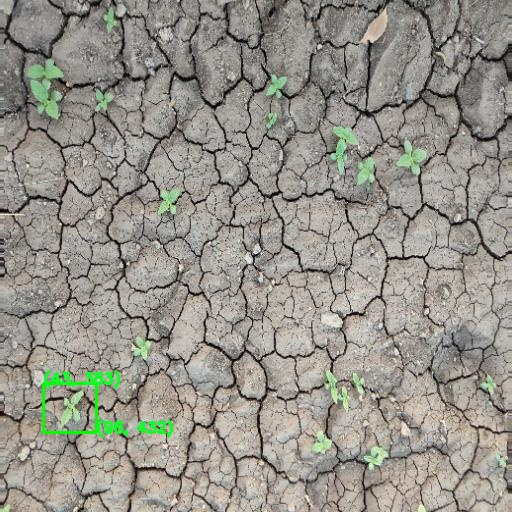

[780] x1, y1, x2, y2:  92 0 512 301
Label: weed


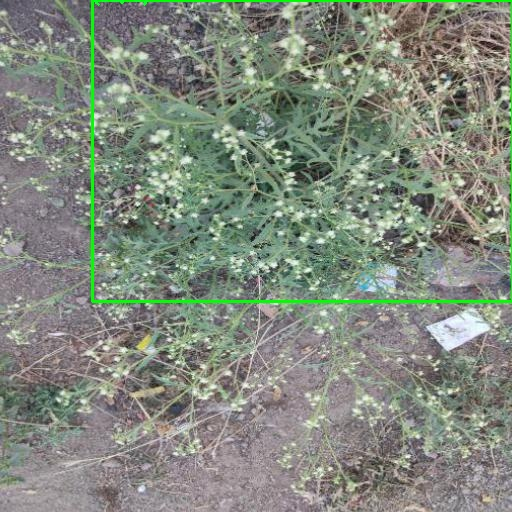

[574] x1, y1, x2, y2:  344 375 504 503
Label: crop


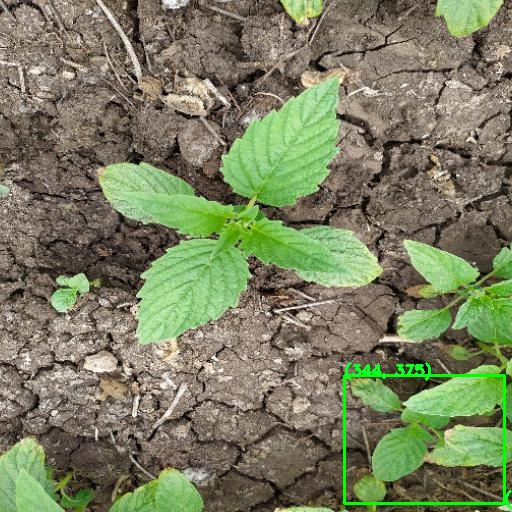

[1845] x1, y1, x2, y2:  175 2 486 154
Label: crop


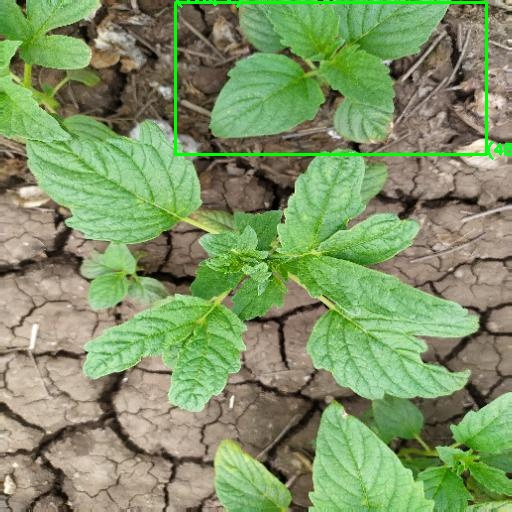

[197] x1, y1, x2, y2:  96 85 419 408
Label: crop


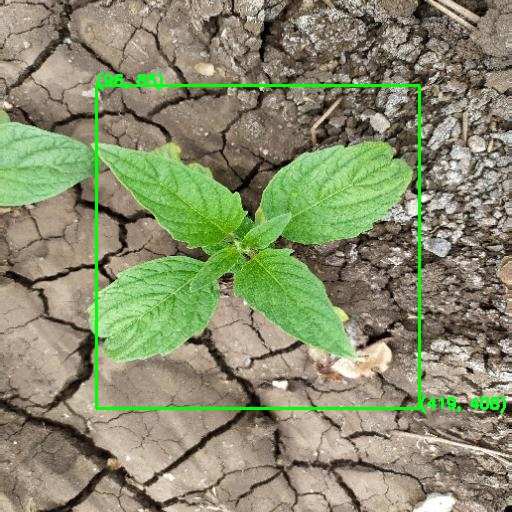

[1245] x1, y1, x2, y2:  148 142 412 343
Label: weed


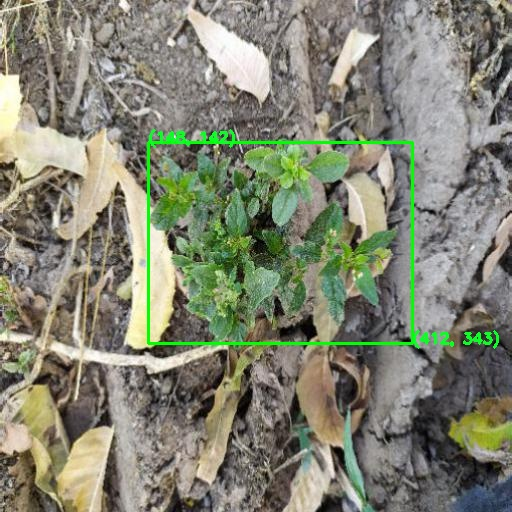

[889] x1, y1, x2, y2:  7 75 511 411
Label: weed


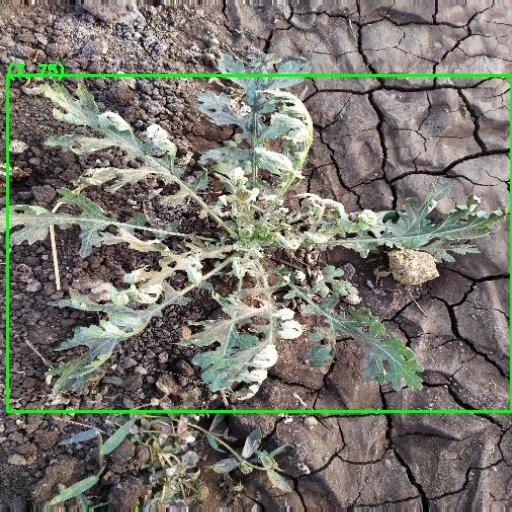

[1829] x1, y1, x2, y2:  56 46 421 444
Label: weed


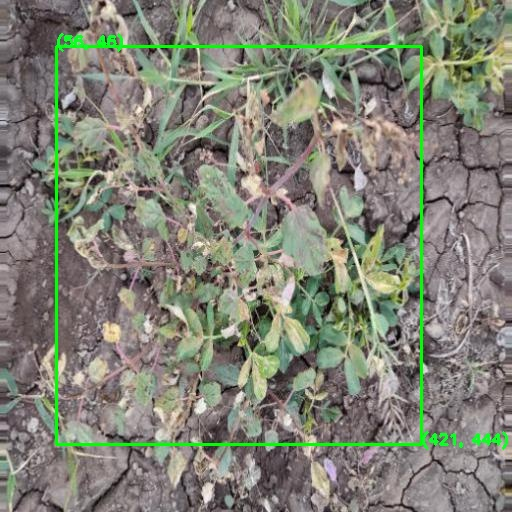

[907] x1, y1, x2, y2:  56 254 104 287
Label: crop


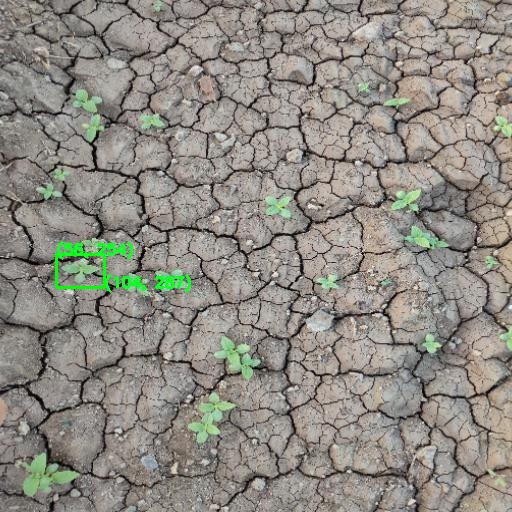

[834] x1, y1, x2, y2:  383 266 460 372
Label: crop


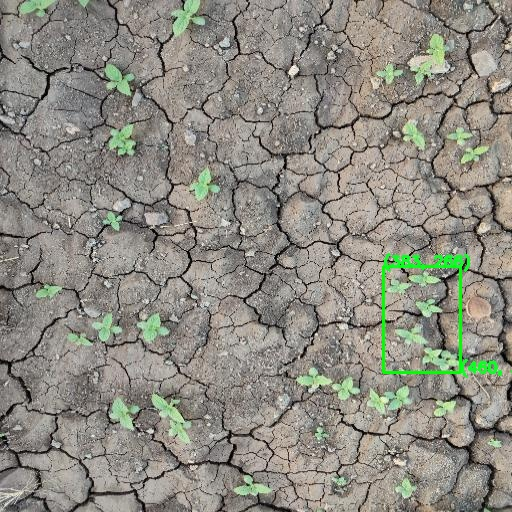

In [13]:
for idx, row in df.sample(10).iterrows():
    name = row["path"].split("/")[-1]
    image = cv2.imread(row["path"])
    x1, y1, x2, y2 = tuple(map(lambda a: int(a),row["bbox"]))
    print(f"[{idx}] x1, y1, x2, y2: ", x1, y1, x2, y2)
    print(f"Label: {row['label']}")
    image = cv2.rectangle(image,(x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(image, f"({x1}, {y1})", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    cv2.putText(image, f"({x2}, {y2})", (x2, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    cv2.imwrite(f"./{name}", image)
    display(Image(filename=f"./{name}"))

# Pre processing data

In [14]:
process_data(data_df = df,
             image_id_col = "image_id",
             bbox_col = "bbox",
             label_col = "label",
             path_col = "path",
             config_filename = Config.CONFIG_FILENAME)

Cloning into 'ultralytics'...
sh: 2: cd: can't cd to ./yolov8


output
|-- images
|   |-- train
|   `-- validation
`-- labels
    |-- train
    `-- validation

6 directories, 0 files
[INFO] Train_SHAPE : (1170, 4), VAL_SHAPE: (130, 4)


Processing validation...: 100%|██████████████████████████████████████████████████| 130/130 [00:03<00:00, 34.43it/s]

[INFO] Done with data processing


In [15]:
!echo "Lets look inside the data.yaml file"
!ls -1 "output/images/train" | wc -l
!cat "./weed_data.yaml"
!echo ""
!head "output/labels/train/agri_0_8252.txt"

Lets look inside the data.yaml file
1170


            train: output/images/train
            val: output/images/validation
            nc: 2
            names: ['crop', 'weed']

            
1 0.761719 0.585938 0.789062 0.585938


# Training YOLO model

In [16]:
# #Loading model
# model = YOLO("yolov8n.pt")

# #Training model
# model.train(data="/kaggle/working/weed_data.yaml", epochs=10)

# BAYESIAN SEARCH

In [17]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Load a model
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 73.9MB/s]


In [19]:
model.train(data="/kaggle/working/weed_data.yaml", epochs=5)
model.export()

Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/weed_data.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-01-27 02:01:08,174	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-01-27 02:01:08,750	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/output/labels/train... 1170 images, 0 backgrounds, 160 corrupt: 100%|██████████| 1170/1170 [00:00<00:00, 1212.93it/s]

train: WARNING ⚠️ /kaggle/working/output/images/train/agri_0_1028.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1387      1.0928      1.0449      1.2012      1.1279      1.3672      1.2148      1.4248      1.3213]
train: WARNING ⚠️ /kaggle/working/output/images/train/agri_0_106.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4023       1.377      1.0645]
train: WARNING ⚠️ /kaggle/working/output/images/train/agri_0_110.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2314      1.2871]
train: WARNING ⚠️ /kaggle/working/output/images/train/agri_0_1130.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3848]
train: WARNING ⚠️ /kaggle/working/output/images/train/agri_0_1140.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3438]
train: WARNING ⚠️ /kaggle/working/output/images/train/agri_0_1332.jpeg

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/output/labels/validation... 130 images, 0 backgrounds, 23 corrupt: 100%|██████████| 130/130 [00:00<00:00, 1510.37it/s]

val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1192.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0361]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1260.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.127      1.2969]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1499.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.084      1.0039       1.292      1.1641      1.2686      1.3164      1.1104      1.3652      1.1699      1.2002]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1590.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3359]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1677.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.166      1.2139]
val: WARNING ⚠️ /kaggle/working/output/images/validat

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.527      2.416      2.063          5        640: 100%|██████████| 64/64 [04:29<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.14s/it]

                   all        107        118       0.67      0.693        0.7      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.456       1.92      1.957          7        640: 100%|██████████| 64/64 [04:26<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all        107        118      0.726       0.62      0.738      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G       1.46      1.808      1.946          6        640: 100%|██████████| 64/64 [04:25<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all        107        118      0.611      0.663      0.641      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.372      1.731      1.882          5        640: 100%|██████████| 64/64 [04:25<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all        107        118       0.82      0.661      0.781      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.366      1.621      1.869          7        640: 100%|██████████| 64/64 [04:25<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

                   all        107        118       0.78      0.731      0.846      0.485



5 epochs completed in 0.387 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (AMD EPYC 7B12)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


                   all        107        118       0.78      0.731      0.846      0.485
                  crop        107         62      0.704      0.823      0.862      0.526
                  weed        107         56      0.856      0.639       0.83      0.444
Speed: 0.9ms preprocess, 84.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (AMD EPYC 7B12)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)

TorchScript: starting export with torch 2.0.0+cpu...
TorchScript: export success ✅ 1.6s, saved as 'runs/detect/train/weights/best.torchscript' (11.9 MB)

Export complete (3.1s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.tor

'runs/detect/train/weights/best.torchscript'

In [68]:
import optuna

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [77]:
import optuna

def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])

    # Define and train the model with the given hyperparameters
    model = YOLO("yolov8n.pt", learning_rate=learning_rate, batch_size=batch_size)
    model.train(data="/kaggle/working/weed_data.yaml", epochs=5)

    # Evaluate the model and return the evaluation metric (e.g., validation accuracy)
    validation_accuracy = metrics.box.map50

    return validation_accuracy

# Perform Bayesian optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-01-27 03:48:06,925] A new study created in memory with name: no-name-b9598fe8-a001-4ed4-abcf-52a227d215a0
[W 2024-01-27 03:48:06,930] Trial 0 failed with parameters: {'learning_rate': 0.00035702353888562074, 'batch_size': 32} because of the following error: TypeError("Model.__init__() got an unexpected keyword argument 'learning_rate'").
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_42/1427288150.py", line 9, in objective
    model = YOLO("yolov8n.pt", learning_rate=learning_rate, batch_size=batch_size)
TypeError: Model.__init__() got an unexpected keyword argument 'learning_rate'
[W 2024-01-27 03:48:06,933] Trial 0 failed with value None.


TypeError: Model.__init__() got an unexpected keyword argument 'learning_rate'

In [ ]:
for result in results:
    # detection
    result.boxes.xyxy   # box with xyxy format, (N, 4)
    result.boxes.xywh   # box with xywh format, (N, 4)
    result.boxes.xyxyn  # box with xyxy format but normalized, (N, 4)
    result.boxes.xywhn  # box with xywh format but normalized, (N, 4)
    result.boxes.conf   # confidence score, (N, 1)
    result.boxes.cls    # cls, (N, 1)

#     # segmentation
#     result.masks.masks     # masks, (N, H, W)
#     result.masks.segments  # bounding coordinates of masks, List[segment] * N

    # classification
    result.probs     # cls prob, (num_class, )

In [ ]:
for result in results:
    for box in result.boxes:
        left, top, right, bottom = np.array(box.xyxy.cpu(), dtype=np.int).squeeze()
        width = right - left
        height = bottom - top
        center = (left + int((right-left)/2), top + int((bottom-top)/2))
        label = results[0].names[int(box.cls)]
        confidence = float(box.conf.cpu())
        
        cv2.rectangle(img, (left, top),(right, bottom), (255, 0, 0), 2)

        cv2.putText(img, label,(left, bottom+20),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)
cv2.imshow('Filtered Frame', img)
cv2.waitKey(0)

In [28]:
metrics = model.val()

Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (AMD EPYC 7B12)


val: Scanning /kaggle/working/output/labels/validation.cache... 130 images, 0 backgrounds, 23 corrupt: 100%|██████████| 130/130 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1192.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0361]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1260.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.127      1.2969]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1499.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.084      1.0039       1.292      1.1641      1.2686      1.3164      1.1104      1.3652      1.1699      1.2002]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1590.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3359]
val: WARNING ⚠️ /kaggle/working/output/images/validation/agri_0_1677.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.166      1.2139]
val: WARNING ⚠️ /kaggle/working/output/images/validat


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


                   all        107        118       0.78      0.731      0.846      0.485
                  crop        107         62      0.704      0.823      0.862      0.526
                  weed        107         56      0.856      0.639       0.83      0.444
Speed: 0.9ms preprocess, 84.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


In [31]:
metrics.box.map    # map50-95


0.48481366412290283

In [32]:
metrics.box.map50  # map50


0.8464107997381504

In [33]:
metrics.box.map75  # map75


0.49758219659771763

In [36]:
metrics.box.maps  

array([    0.52561,     0.44401])

In [35]:
results = model(['/kaggle/working/agri_0_417.jpeg'])


0: 640x640 1 weed, 90.6ms
Speed: 2.5ms preprocess, 90.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


In [48]:
metrics.confusion_matrix

In [39]:
# Function to perform ship detections
def weed_detect(img_path):

    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img



0: 640x640 1 weed, 96.0ms
Speed: 2.8ms preprocess, 96.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crop, 86.3ms
Speed: 3.2ms preprocess, 86.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 weeds, 83.2ms
Speed: 2.3ms preprocess, 83.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 84.3ms
Speed: 2.1ms preprocess, 84.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 weed, 85.5ms
Speed: 3.1ms preprocess, 85.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 weed, 83.0ms
Speed: 2.8ms preprocess, 83.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crop, 90.0ms
Speed: 2.8ms preprocess, 90.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 weeds, 89.5ms
Speed: 2.5ms preprocess, 89.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 64

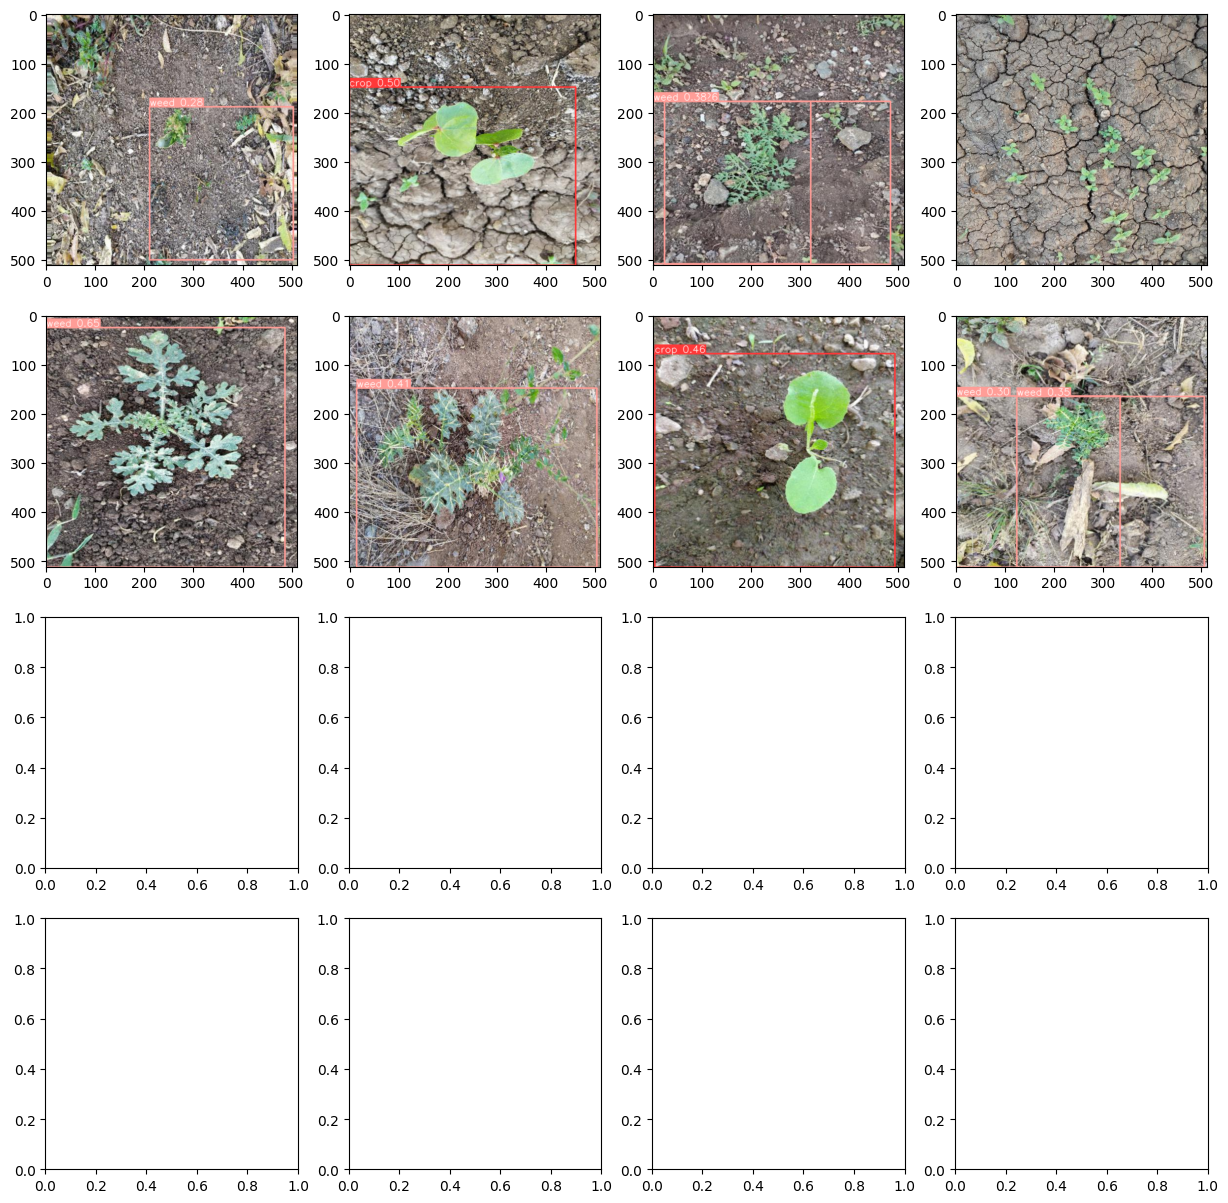

In [41]:
import random
import os

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Exclude any images from a specific source
image_files = [file for file in image_files if file.endswith('.jpeg')]

# Select 16 random images from the list
selected_images = random.sample(image_files, 8)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):

    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = weed_detect(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('on')

# Adjust the spacing between the subplots
plt.subplots_adjust()


# metrics

## Confusion Matrix

In [67]:
print(ultralytics.utils.metrics.ConfusionMatrix)

<class 'ultralytics.utils.metrics.ConfusionMatrix'>


In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

## IoU

In [2]:

from typing import List, Tuple
from PIL import Image

def calculate_iou(box1, box2):
    # Calculate the intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate the area of intersection rectangle
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    # Calculate the union area
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area
    
    return iou



In [3]:
box1 = (0.635469, 0.834961, 0.537500, 0.330078)
box2 = (0.658828, 0.869922, 0.524219, 0.330000)
iou_score = calculate_iou(box1, box2)
print("IoU:",iou_score)


IoU: 0.8914860250517546


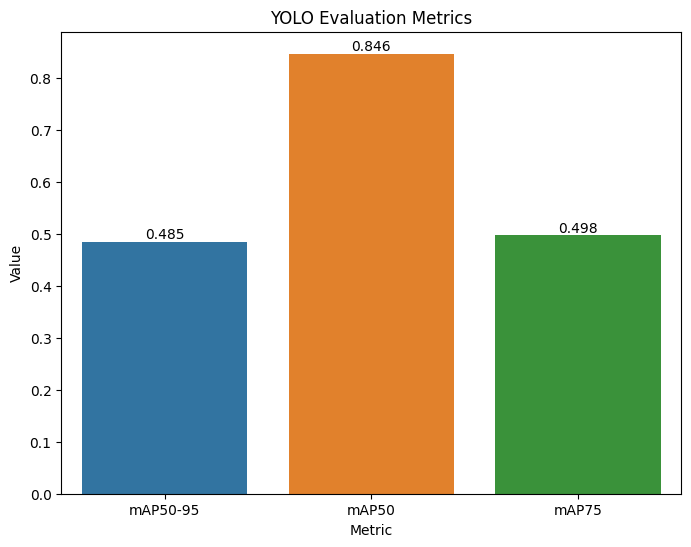

In [53]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

In [50]:
act1 = open('/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_3374.txt')
act1.read()


'1 0.605469 0.834961 0.437500 0.330078\n1 0.768555 0.423828 0.400391 0.332031\n1 0.300781 0.410156 0.355469 0.375000\n'

In [49]:
pred1 = open('/kaggle/working/output/labels/train/agri_0_3374.txt')
pred1.read()

'1 0.798828 1.169922 0.824219 1.000000\n1 1.052734 0.551758 0.968750 0.587891\n1 0.359375 0.518555 0.476562 0.595703\n'

In [ ]:
Config.COLS

In [ ]:
# Define the fitness function to evaluate a model
def fitness(model, train_data_generator, val_data_generator):
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    cnn_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)
    _, accuracy = model.evaluate_generator(val_data_generator)
    return accuracy

# Define the Crow Search Optimization algorithm
def crow_search_optimization(fitness_func, n_population, n_iterations, train_data_generator, val_data_generator, w_min=-1, w_max=1, a_min=0, a_max=1):
    # Initialize the population of crows with random positions and velocities
    positions = np.random.uniform(w_min, w_max, size=(n_population, model.count_params()))
    velocities = np.random.uniform(a_min, a_max, size=(n_population, model.count_params()))
    best_position = None
    best_fitness = 0

    # Main optimization loop
    for iteration in range(n_iterations):
        # Evaluate fitness of each crow and update the best position
        for i in range(n_population):
            # Decode the position into model weights and evaluate fitness
            model.set_weights(decode_position(positions[i], model))
            fitness = fitness_func(model, train_data_generator, val_data_generator)

            # Update the best position
            if fitness > best_fitness:
                best_fitness = fitness
                best_position = positions[i]

        # Update the velocity of each crow based on the best position
        for i in range(n_population):
            r1 = np.random.rand(model.count_params())
            r2 = np.random.rand(model.count_params())
            velocities[i] = 0.5 * velocities[i] + r1 * (best_position - positions[i]) + r2 * (best_position - positions[i])
            positions[i] = np.clip(positions[i] + velocities[i], w_min, w_max)

    # Return the best model architecture found
    model.set_weights(decode_position(best_position, model))
    return model

# Helper function to decode the position into model weights
def decode_position(position, model):
    shapes = [w.shape for w in model.get_weights()]
    weights = []
    start = 0
    for shape in shapes:
        size = np.prod(shape)
        weights.append(np.reshape(position[start:start+size], shape))
        start += size
    return weights

In [ ]:
model = crow_search_optimization(
    fitness_func=fitness,
    n_population=1,
    n_iterations=1,
    train_data_generator=train_data,
    val_data_generator=val_data,
    w_min=-1,
    w_max=1,
    a_min=0,
    a_max=1
)